The purpose of this notebook is to match ripple times to ripplekons files.

In [1]:
%matplotlib inline
%reload_ext autoreload

%autoreload 2
%qtconsole
%config InlineBackend.figure_format = 'retina'


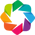

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import loren_frank_data_processing as lfdp
import spectral_connectivity
import ripple_detection
import replay_classification

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
from src.parameters import ANIMALS

In [4]:
epoch_key = ('JZ1', 1, 2)

In [5]:
tetrode_info = lfdp.make_tetrode_dataframe(ANIMALS).xs(epoch_key, drop_level=False)
is_brain_areas = tetrode_info.area.isin(['ca1'])
tetrode_keys = tetrode_info[is_brain_areas].index.tolist()

tetrode_info[is_brain_areas].loc[:, ['area']]

area
animal day epoch tetrode_number     
JZ1    1   2     16              ca1
                 17              ca1
                 18              ca1
                 19              ca1
                 20              ca1
                 21              ca1
                 22              ca1
                 23              ca1
                 24              ca1
                 25              ca1
                 26              ca1
                 27              ca1
                 28              ca1
                 29              ca1
                 30              ca1

In [6]:
from loren_frank_data_processing.tetrodes import get_LFP_filename, loadmat, logger

def reconstruct_time(start_time, n_samples, sampling_frequency):
    '''Reconstructs the recording time

    Parameters
    ----------
    start_time : float
        Start time of recording.
    n_samples : int
        Number of samples in recording.
    sampling_frequency : float
        Number of samples per time

    Returns
    -------
    time : pandas Index

    '''
    return pd.TimedeltaIndex(
        start_time + np.arange(n_samples) / sampling_frequency, name='time', unit='s')


def get_LFP_dataframe(tetrode_key, animals):
    '''Gets the LFP data for a given epoch and tetrode.

    Parameters
    ----------
    tetrode_key : tuple
        Unique key identifying the tetrode. Elements are
        (animal_short_name, day, epoch, tetrode_number).
    animals : dict of named-tuples
        Dictionary containing information about the directory for each
        animal. The key is the animal_short_name.

    Returns
    -------
    LFP : pandas dataframe
        Contains the electric potential and time
    '''
    try:
        lfp_file = loadmat(get_LFP_filename(tetrode_key, animals))
        lfp_data = lfp_file['eeg'][0, -1][0, -1][0, -1]
        lfp_time = reconstruct_time(lfp_data['starttime'][0, 0].item(),
                                    lfp_data['data'][0, 0].size,
                                    lfp_data['samprate'][0, 0].squeeze())
        return pd.Series(
            data=lfp_data['data'][0, 0].squeeze(),
            index=lfp_time,
            name='electric_potential')
    except (FileNotFoundError, TypeError):
        logger.warning('Failed to load file: {0}'.format(
            get_LFP_filename(tetrode_key, animals)))

hippocampus_lfps = pd.concat(
    [get_LFP_dataframe(tetrode_key, ANIMALS)
     for tetrode_key in tetrode_keys], axis=1, keys=tetrode_keys)
sampling_frequency = 1500
time = hippocampus_lfps.index

def _time_function(epoch_key, animals):
    return time

speed = lfdp.get_interpolated_position_dataframe(
    epoch_key, ANIMALS, time_function=_time_function).speed



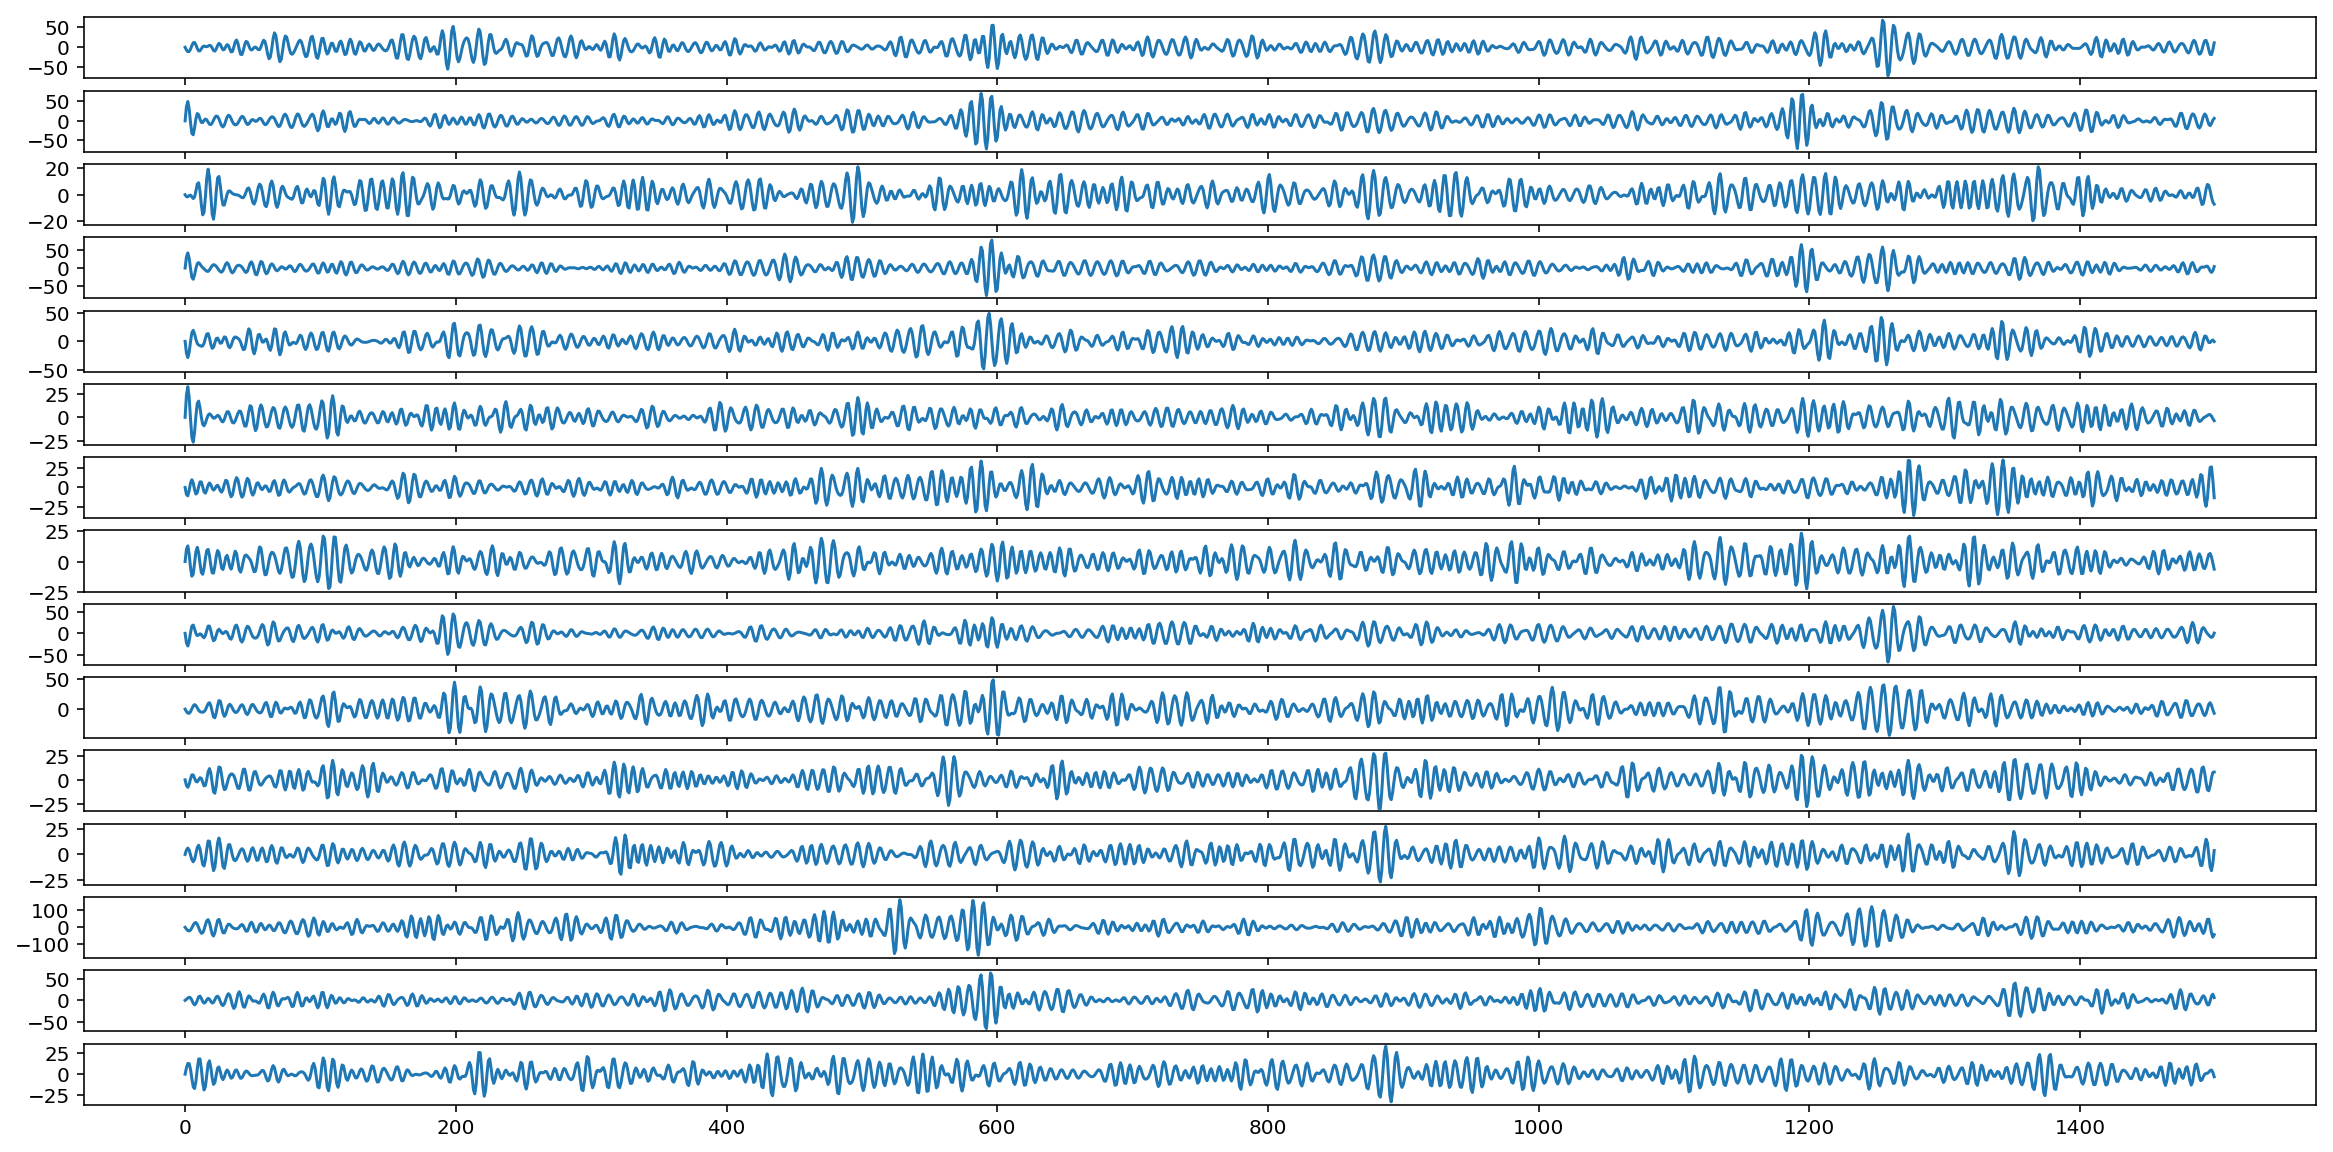

In [7]:
from scipy.signal import filtfilt
import ripple_detection

filter_numerator, filter_denominator = ripple_detection.core._get_ripplefilter_kernel()
filtered_lfp = []
for lfp in hippocampus_lfps.values.T:
    filtered_lfp.append(filtfilt(
        filter_numerator, filter_denominator, lfp, axis=0))
    
filtered_lfp = np.stack(filtered_lfp, axis=1)

n_lfps = hippocampus_lfps.shape[1]

fig, axes = plt.subplots(n_lfps, 1, sharex=True, figsize=(20, 10))
for ind, ax in enumerate(axes):
    ax.plot(filtered_lfp[:1500, ind])

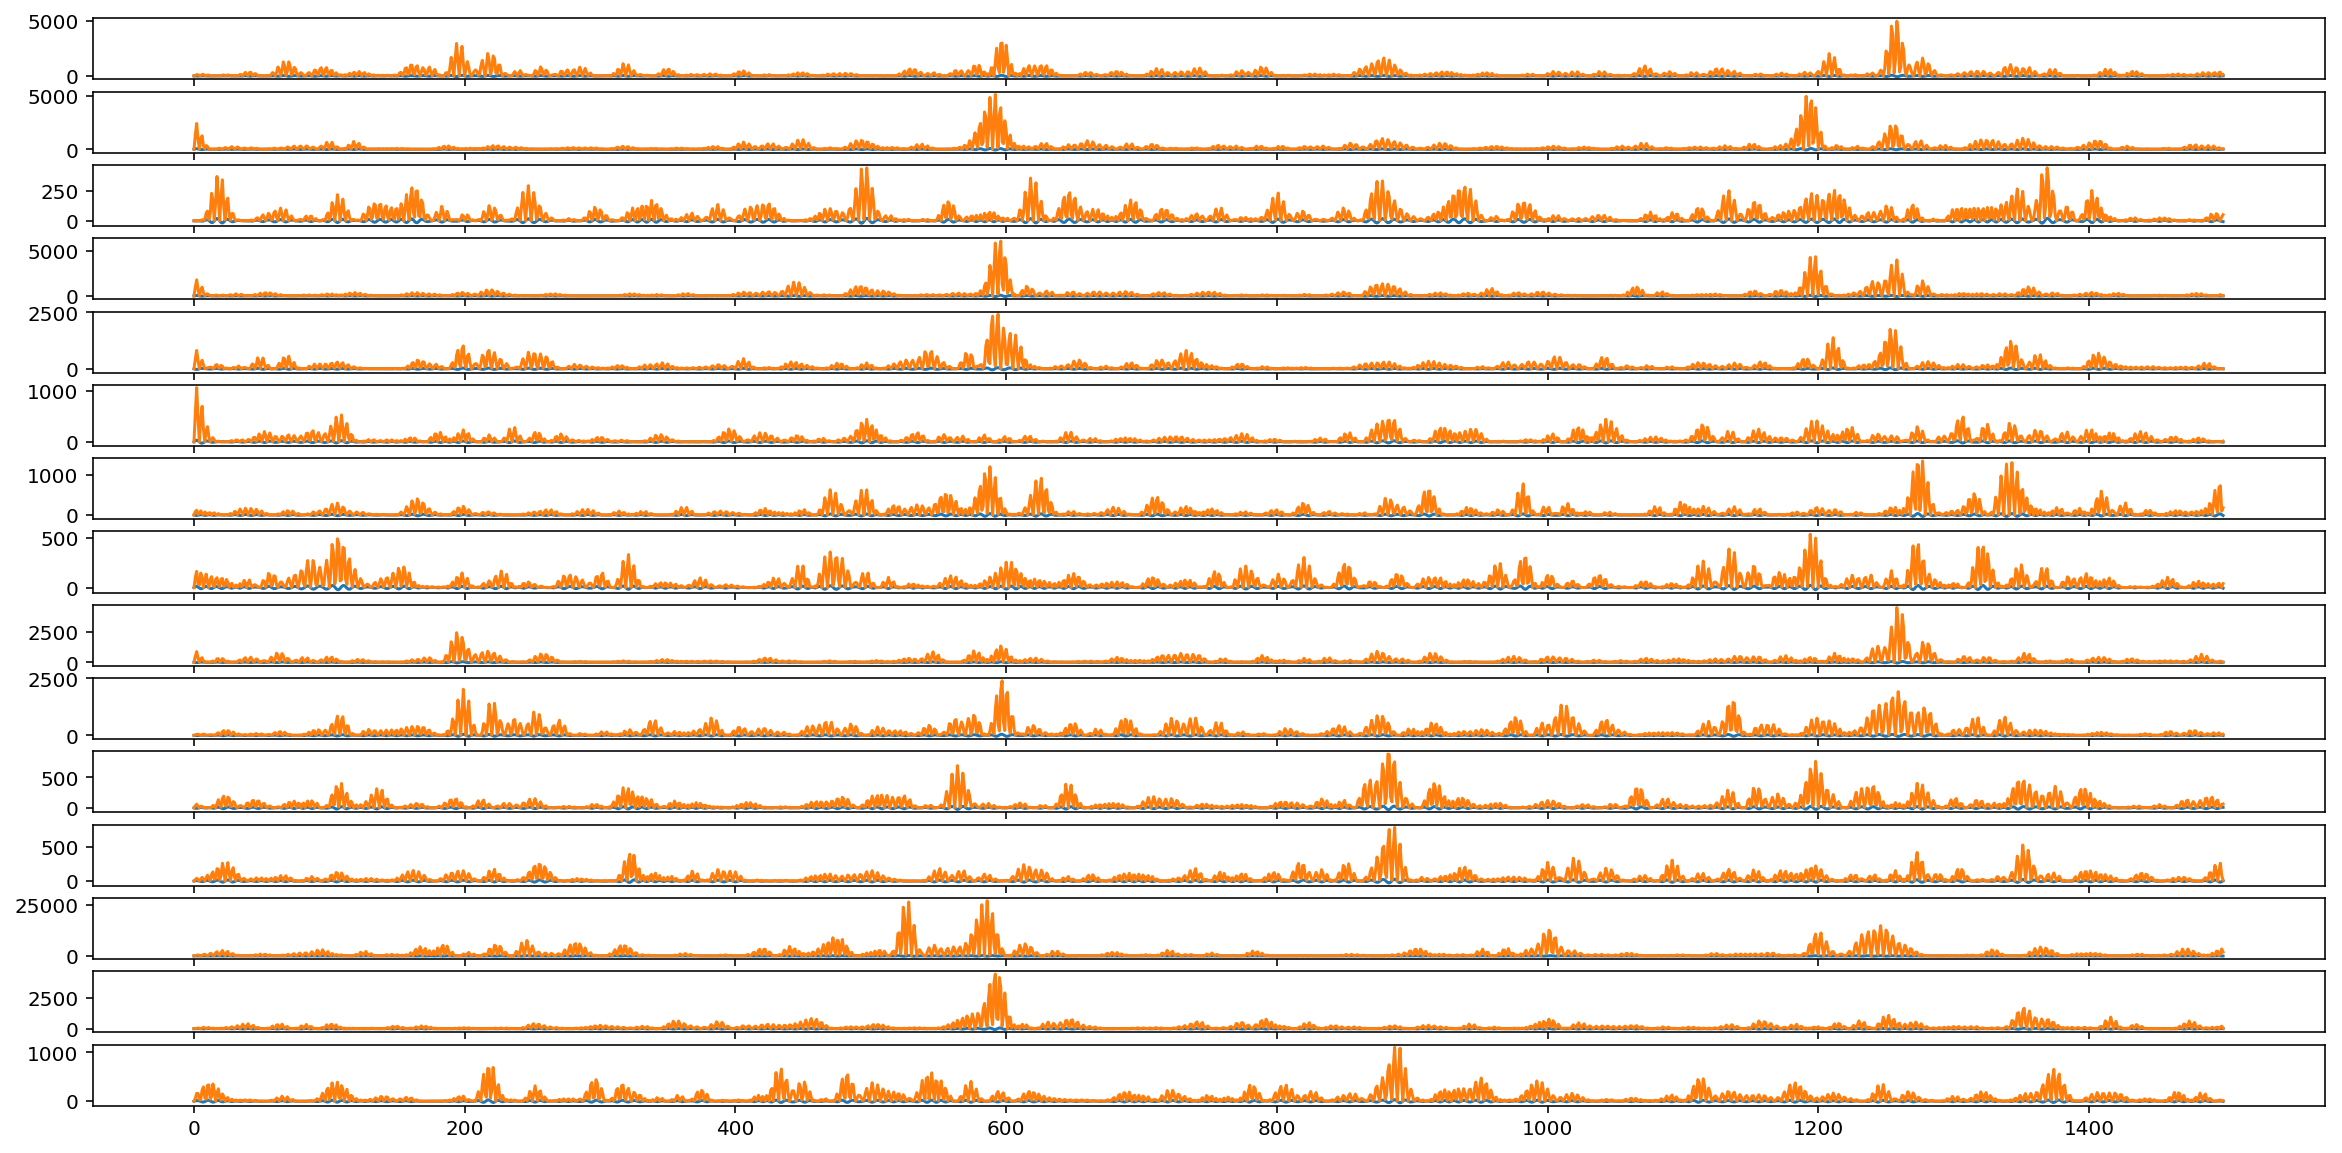

In [8]:
squared_amplitude = filtered_lfp ** 2

fig, axes = plt.subplots(n_lfps, 1, sharex=True, figsize=(20, 10))
for ind, ax in enumerate(axes):
    ax.plot(filtered_lfp[:1500, ind])
    ax.plot(squared_amplitude[:1500, ind])

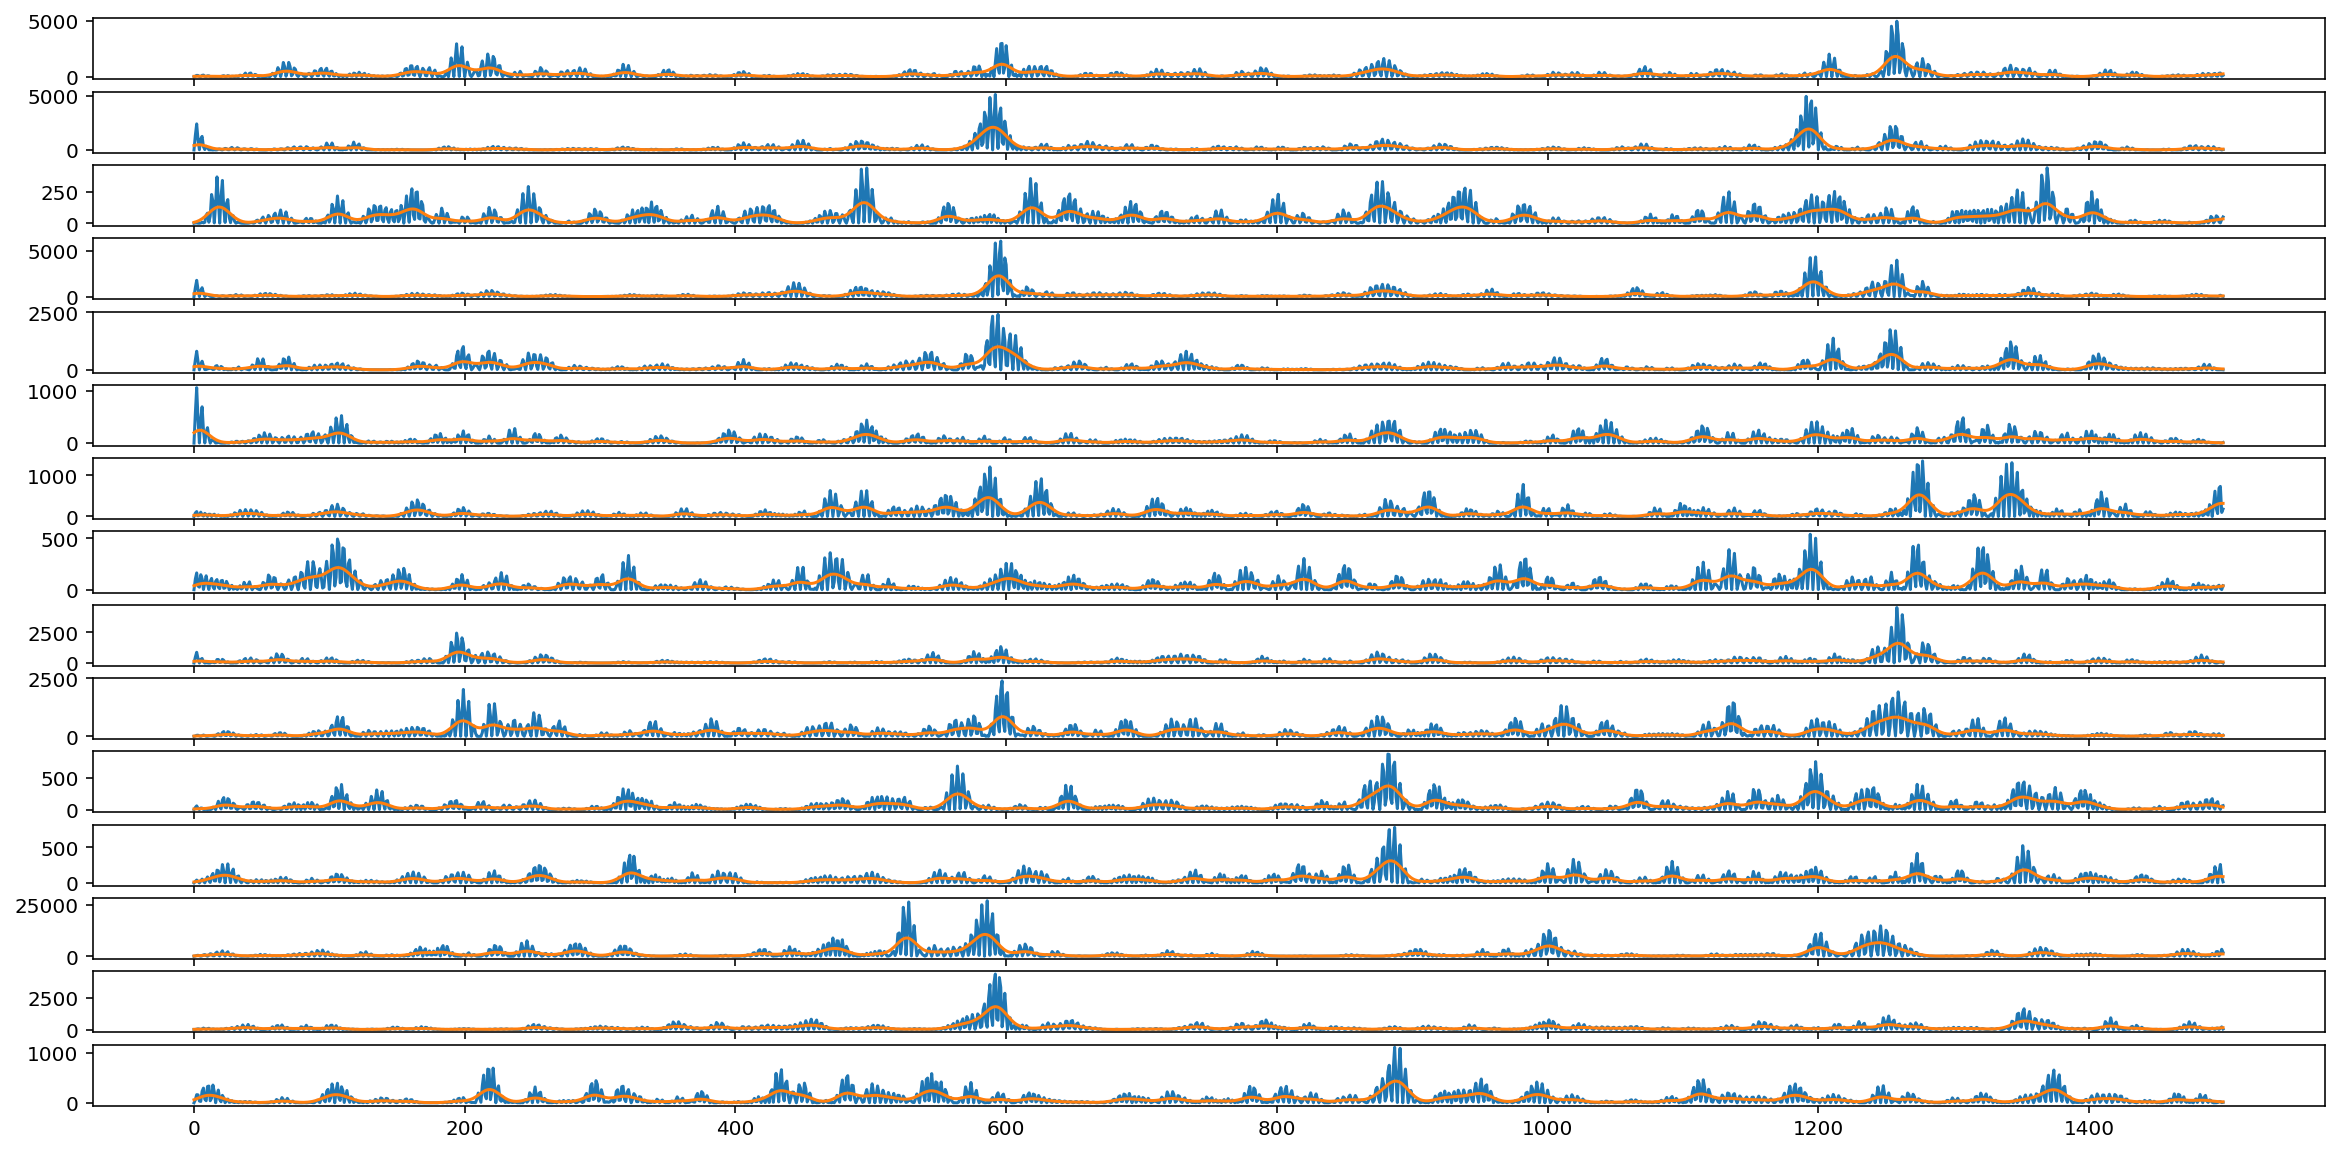

In [9]:
smoothing_sigma = 0.004
smoothed_square_amplitude = ripple_detection.core.gaussian_smooth(
    squared_amplitude, smoothing_sigma, sampling_frequency, axis=0)

fig, axes = plt.subplots(n_lfps, 1, sharex=True, figsize=(20, 10))
for ind, ax in enumerate(axes):
    ax.plot(squared_amplitude[:1500, ind])
    ax.plot(smoothed_square_amplitude[:1500, ind])

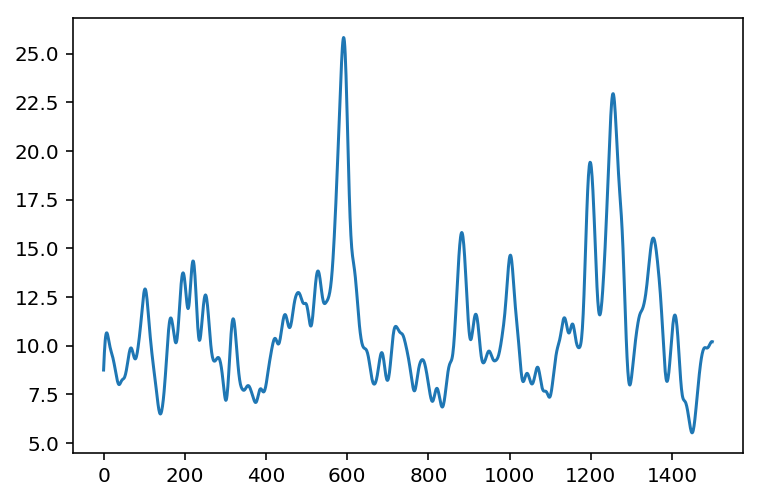

In [10]:
powertrace = np.mean(np.sqrt(smoothed_square_amplitude), axis=1)
plt.plot(powertrace[:1500])

In [11]:
time = hippocampus_lfps.index
minimum_duration = pd.Timedelta(milliseconds=15)
zscore_threshold = nstd = 3

baseline = np.mean(powertrace)
stdev = np.std(powertrace)
thresh = baseline + nstd * stdev

candidate_ripple_times = ripple_detection.core.threshold_by_zscore(
        powertrace, time, minimum_duration, zscore_threshold)

In [12]:
index = pd.Index(np.arange(len(candidate_ripple_times)) + 1,
                     name='ripple_number')
candidate_ripple_times = pd.DataFrame(candidate_ripple_times, columns=['start_time', 'end_time'],
                        index=index)

In [262]:
import scipy.io
animal, day, epoch = epoch_key

consensus_ripples = scipy.io.loadmat('../Raw-Data/JZ1/JZ1ca1rippleskons01.mat')
ripple_start_time = consensus_ripples['ca1rippleskons'][0, 0][0, epoch - 1][0, 0][0, 0]['starttime'].squeeze()
ripple_end_time = consensus_ripples['ca1rippleskons'][0, 0][0, epoch - 1][0, 0][0, 0]['endtime'].squeeze()
ripple_number = pd.Index(np.arange(len(ripple_start_time)) + 1, name='ripple_number')

ripple_times2 = pd.DataFrame(
    np.stack((ripple_start_time, ripple_end_time), axis=1),
    index=ripple_number, columns=['start_time', 'end_time']).apply(
            pd.to_timedelta, unit='s')


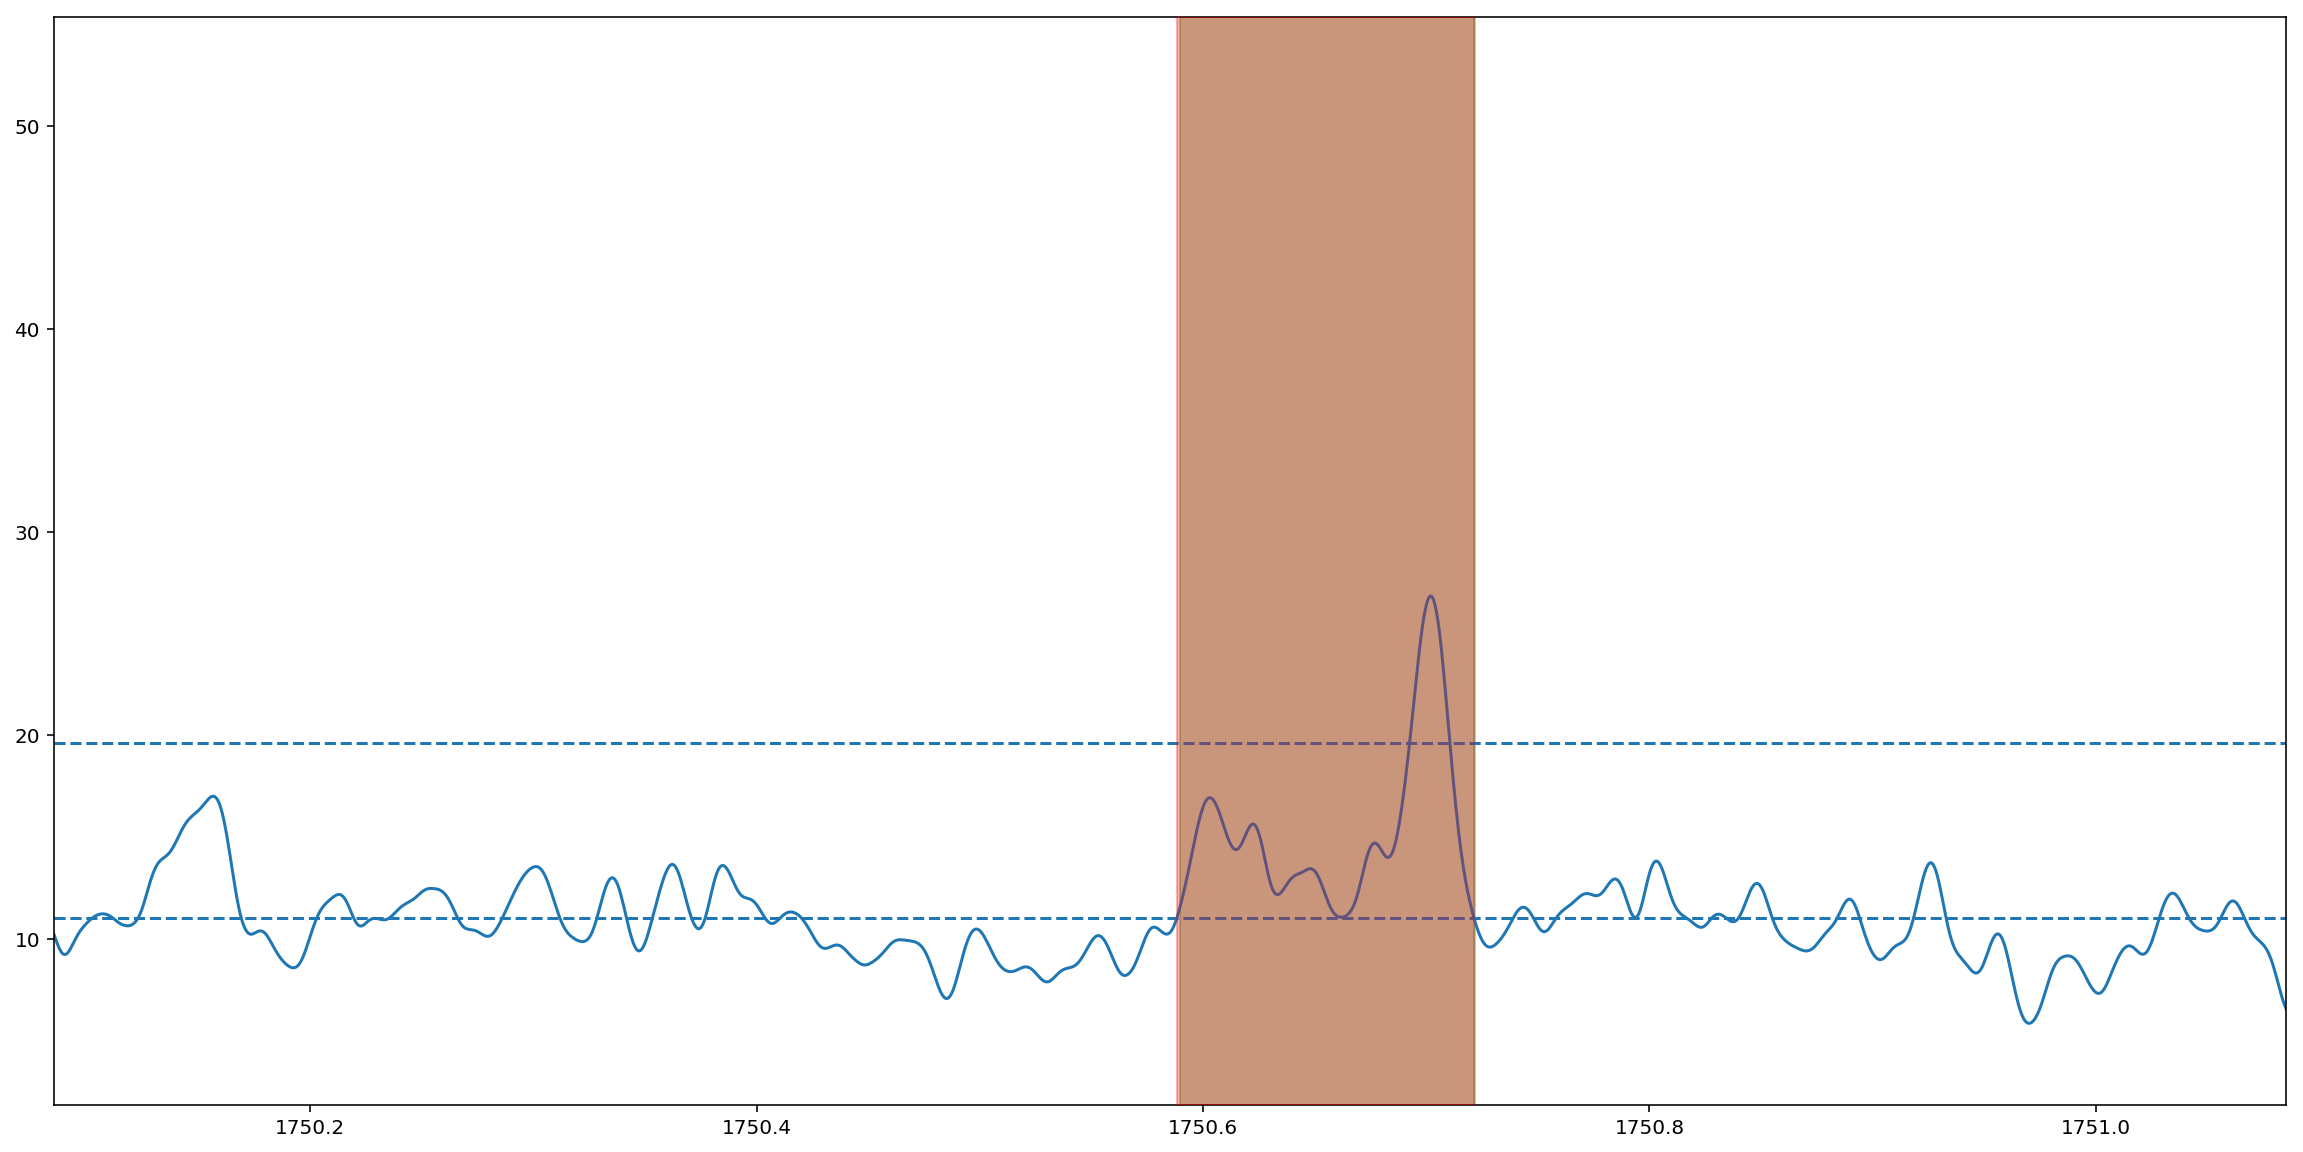

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for ripple in candidate_ripple_times.index:
    c = candidate_ripple_times.loc[ripple]
    ax.axvspan(c.start_time.total_seconds(), c.end_time.total_seconds(), color='red', alpha=0.3, zorder=100)
    
for ripple in ripple_times2.index:
    c = ripple_times2.loc[ripple]
    ax.axvspan(c.start_time.total_seconds(), c.end_time.total_seconds(), color='green', alpha=0.3)

ax.plot(time.total_seconds(), powertrace)
    
ax.set_xlim((time.min().total_seconds() + 70, time.min().total_seconds() + 71))

ax.axhline(baseline, linestyle='--')
ax.axhline(thresh, linestyle='--')

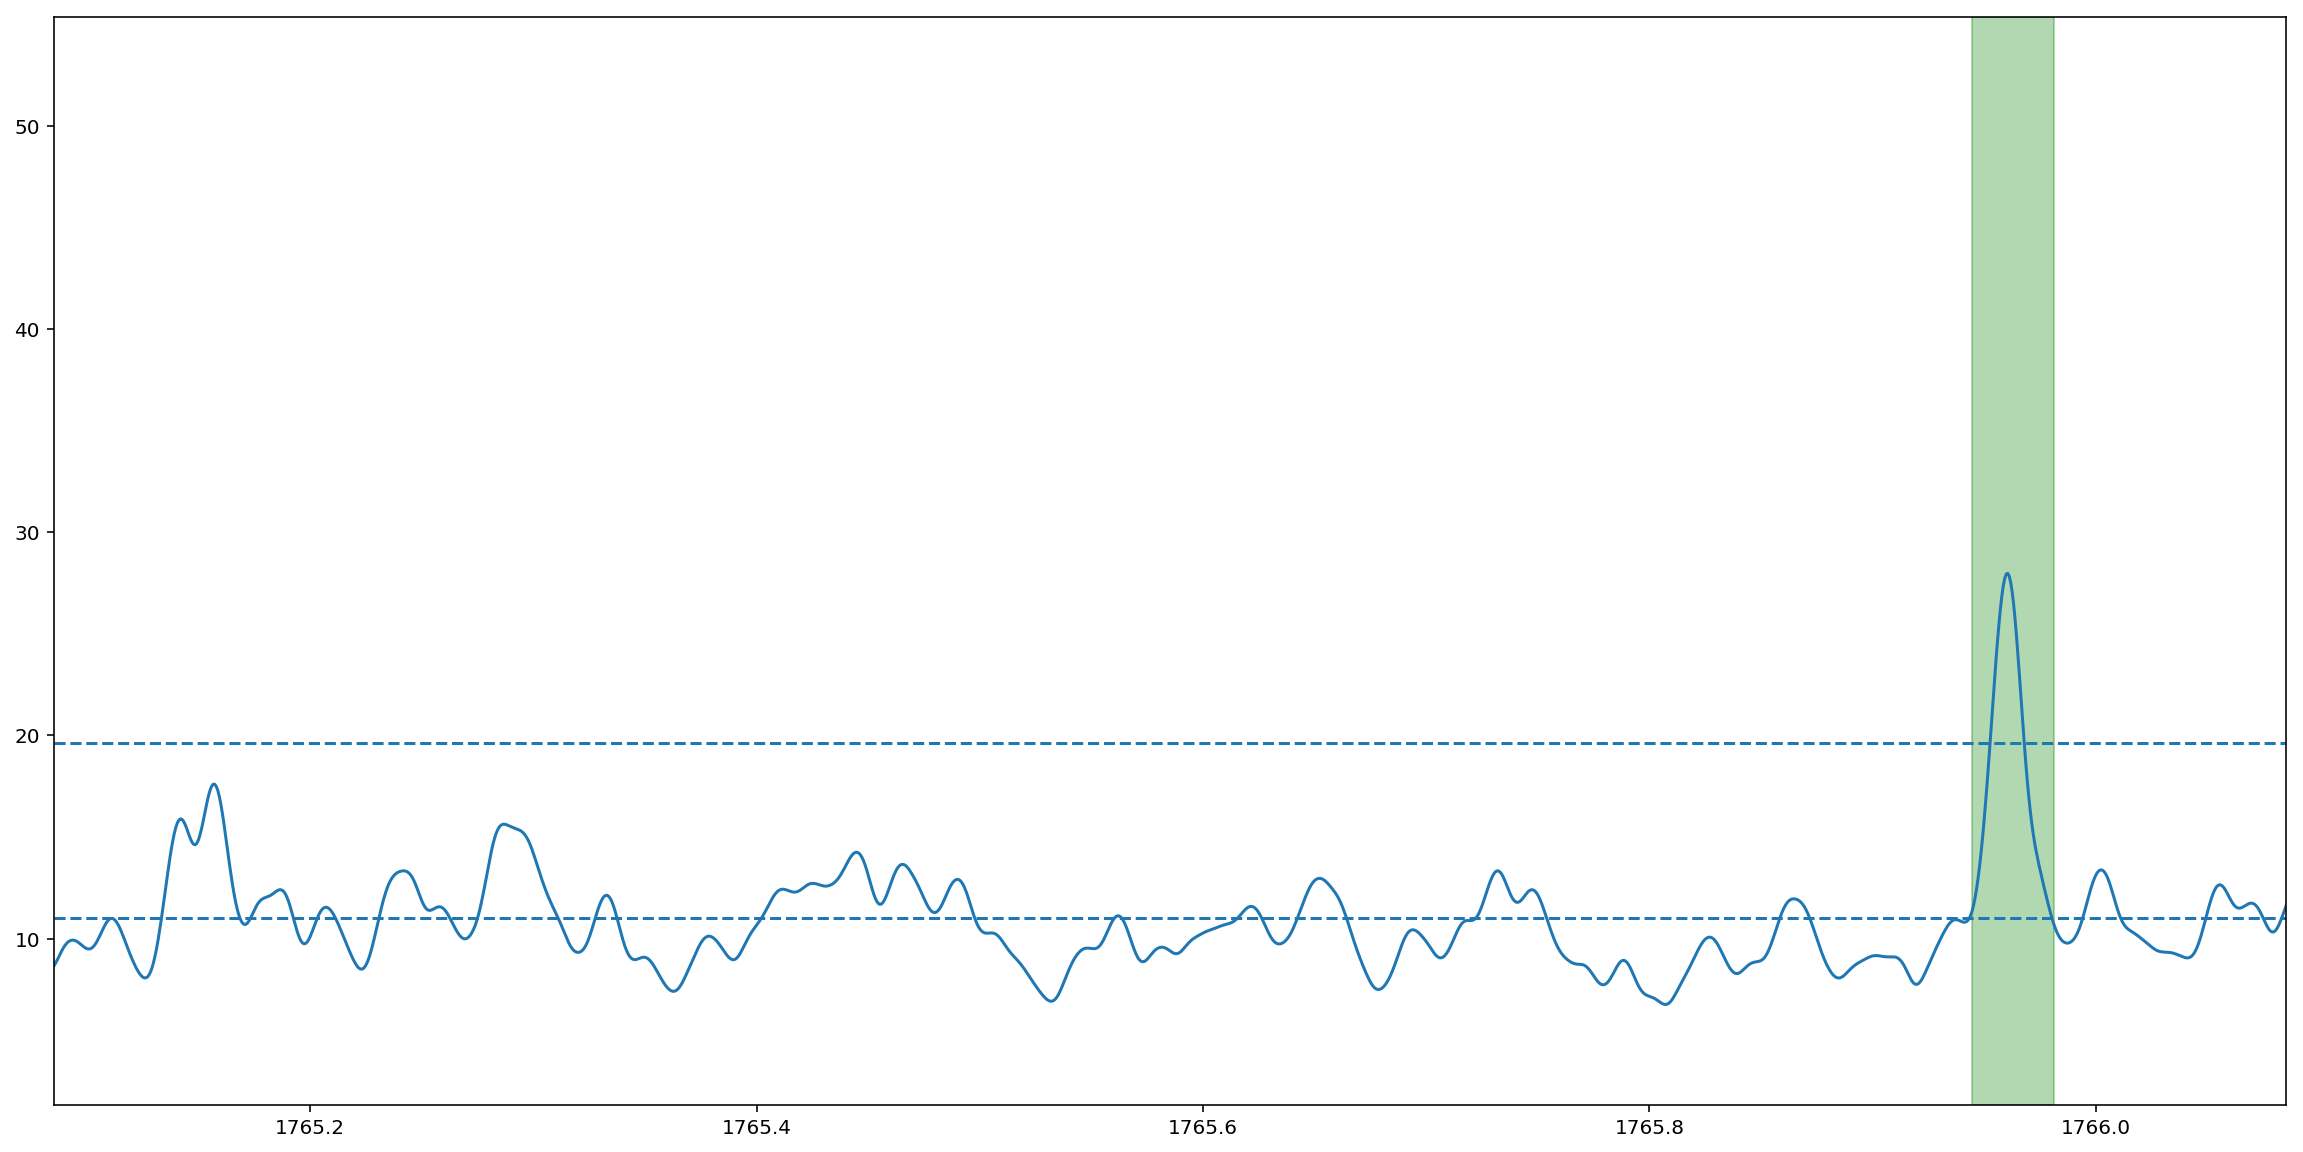

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for ripple in candidate_ripple_times.index:
    c = candidate_ripple_times.loc[ripple]
    ax.axvspan(c.start_time.total_seconds(), c.end_time.total_seconds(), color='red', alpha=0.3, zorder=100)
    
for ripple in ripple_times2.index:
    c = ripple_times2.loc[ripple]
    ax.axvspan(c.start_time.total_seconds(), c.end_time.total_seconds(), color='green', alpha=0.3)

ax.plot(time.total_seconds(), powertrace)
    
ax.set_xlim((time.min().total_seconds() + 85, time.min().total_seconds() + 86))

ax.axhline(baseline, linestyle='--')
ax.axhline(thresh, linestyle='--')

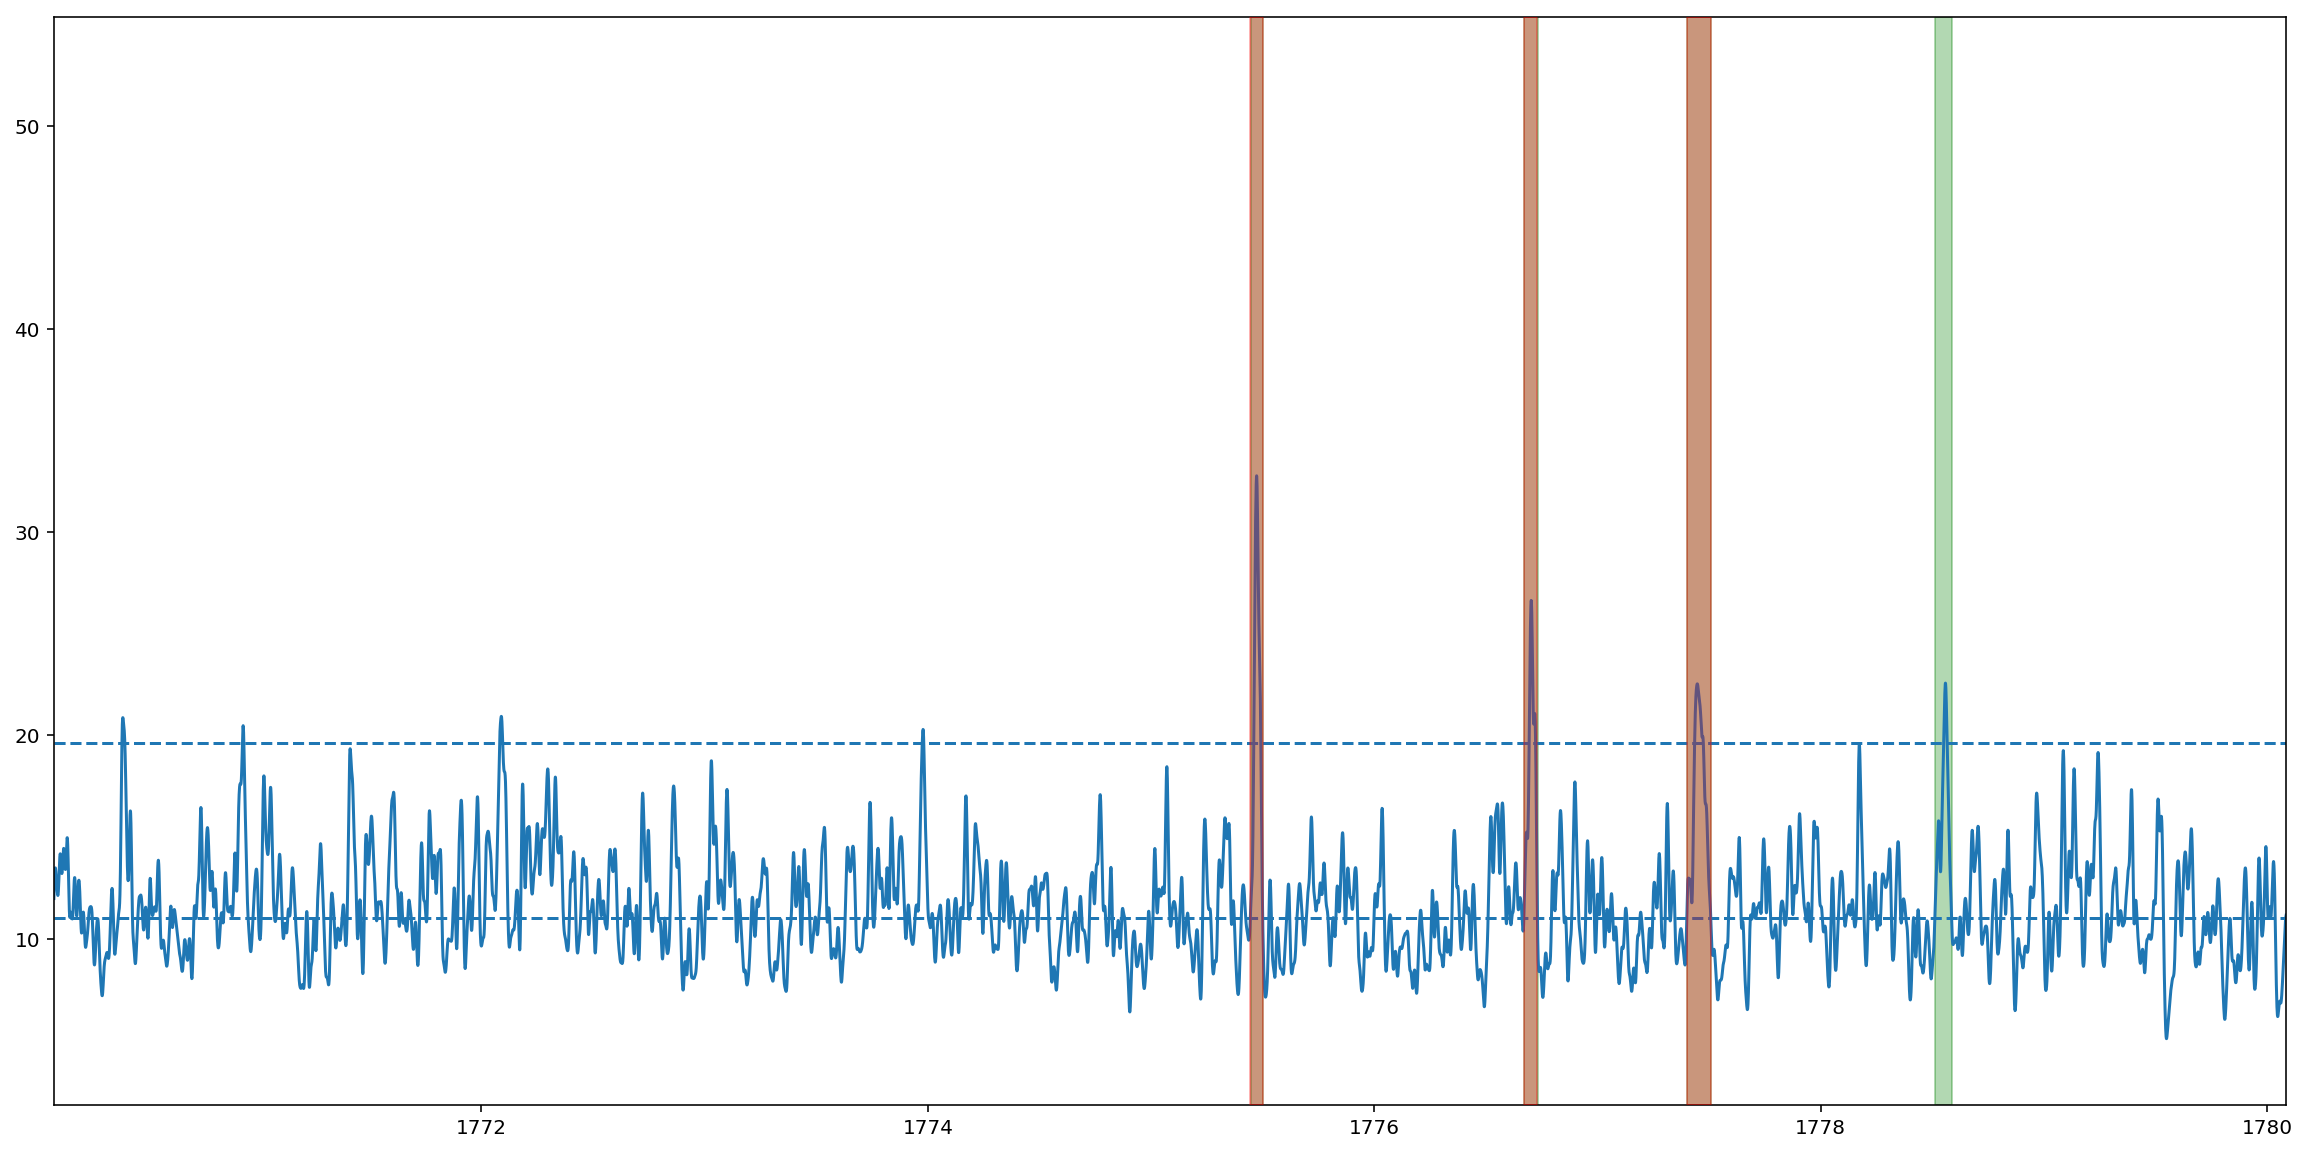

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for ripple in candidate_ripple_times.index:
    c = candidate_ripple_times.loc[ripple]
    ax.axvspan(c.start_time.total_seconds(), c.end_time.total_seconds(), color='red', alpha=0.3, zorder=100)
    
for ripple in ripple_times2.index:
    c = ripple_times2.loc[ripple]
    ax.axvspan(c.start_time.total_seconds(), c.end_time.total_seconds(), color='green', alpha=0.3)

ax.plot(time.total_seconds(), powertrace)
    
ax.set_xlim((time.min().total_seconds() + 90, time.min().total_seconds() + 100))

ax.axhline(baseline, linestyle='--')
ax.axhline(thresh, linestyle='--')

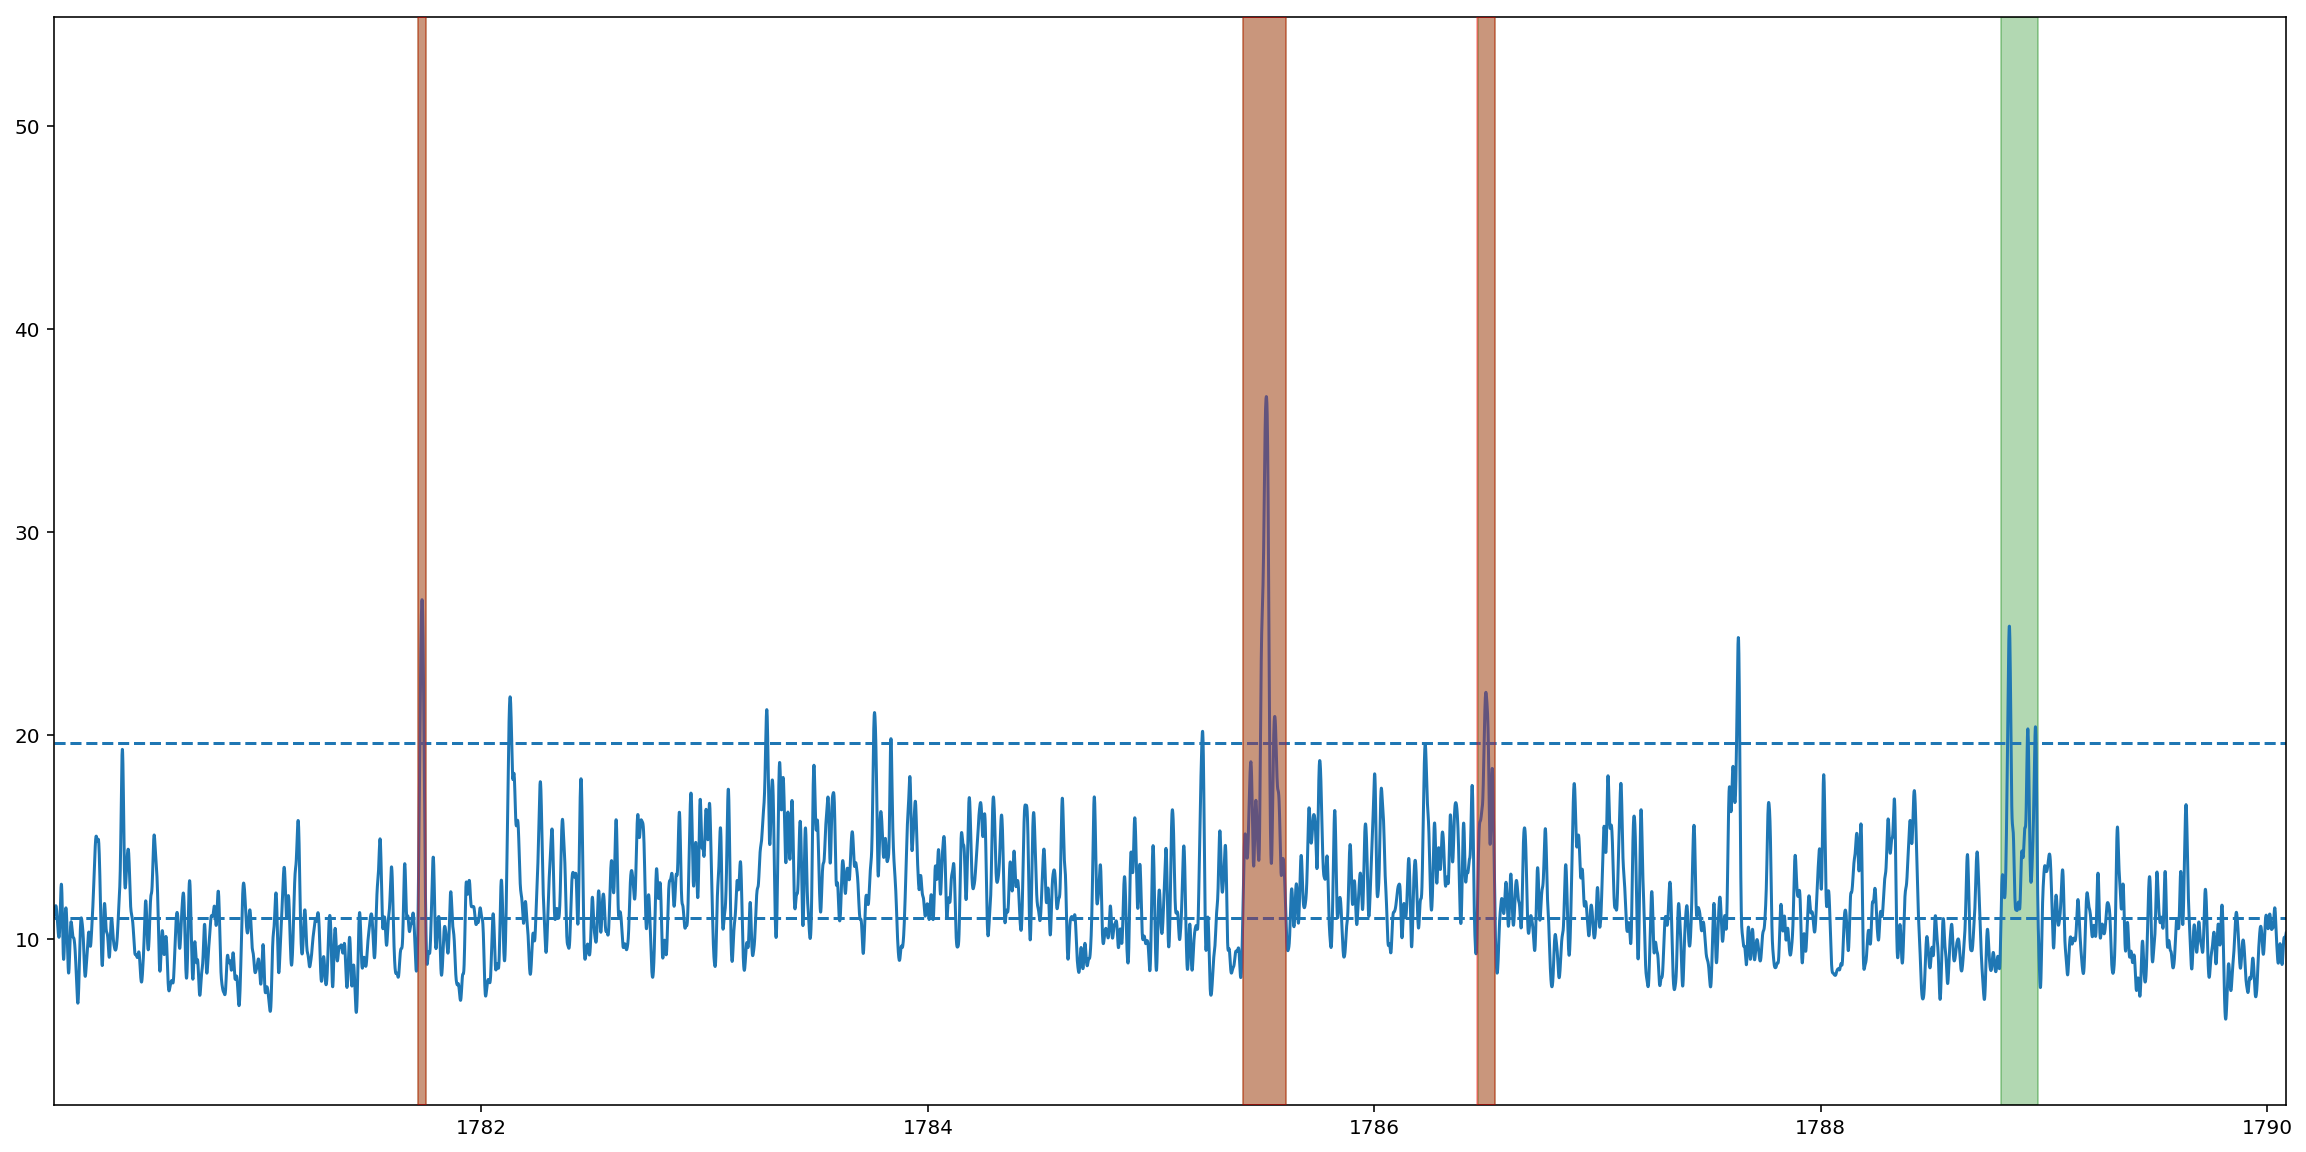

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for ripple in candidate_ripple_times.index:
    c = candidate_ripple_times.loc[ripple]
    ax.axvspan(c.start_time.total_seconds(), c.end_time.total_seconds(), color='red', alpha=0.3, zorder=100)
    
for ripple in ripple_times2.index:
    c = ripple_times2.loc[ripple]
    ax.axvspan(c.start_time.total_seconds(), c.end_time.total_seconds(), color='green', alpha=0.3)

ax.plot(time.total_seconds(), powertrace)
    
ax.set_xlim((time.min().total_seconds() + 100, time.min().total_seconds() + 110))

ax.axhline(baseline, linestyle='--')
ax.axhline(thresh, linestyle='--')

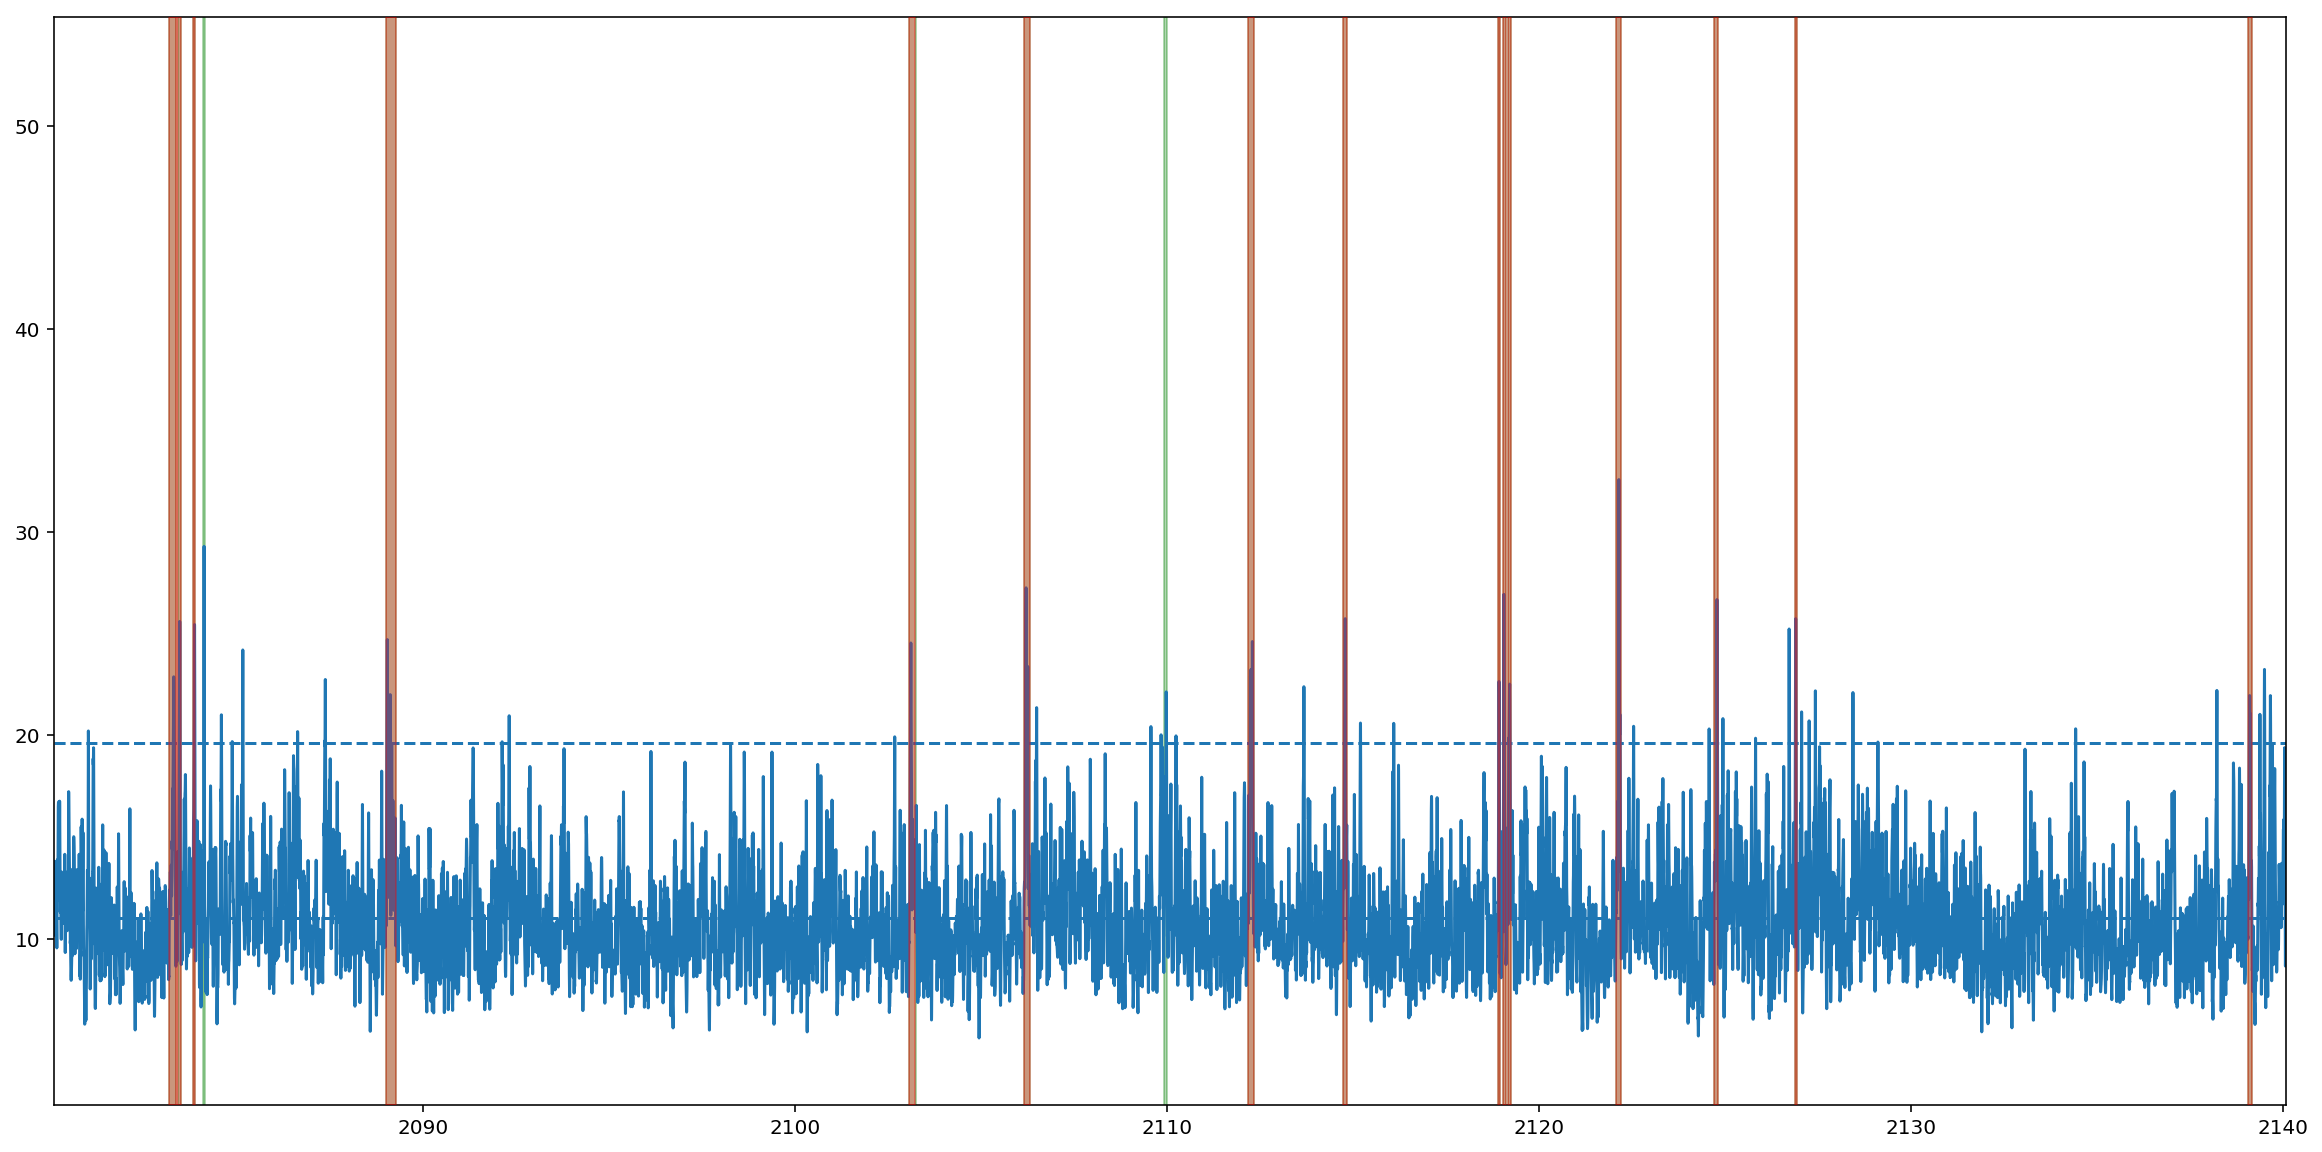

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for ripple in candidate_ripple_times.index:
    c = candidate_ripple_times.loc[ripple]
    ax.axvspan(c.start_time.total_seconds(), c.end_time.total_seconds(), color='red', alpha=0.3, zorder=100)
    
for ripple in ripple_times2.index:
    c = ripple_times2.loc[ripple]
    ax.axvspan(c.start_time.total_seconds(), c.end_time.total_seconds(), color='green', alpha=0.3)

ax.plot(time.total_seconds(), powertrace)
    
ax.set_xlim((time.min().total_seconds() + 400, time.min().total_seconds() + 460))

ax.axhline(baseline, linestyle='--')
ax.axhline(thresh, linestyle='--')

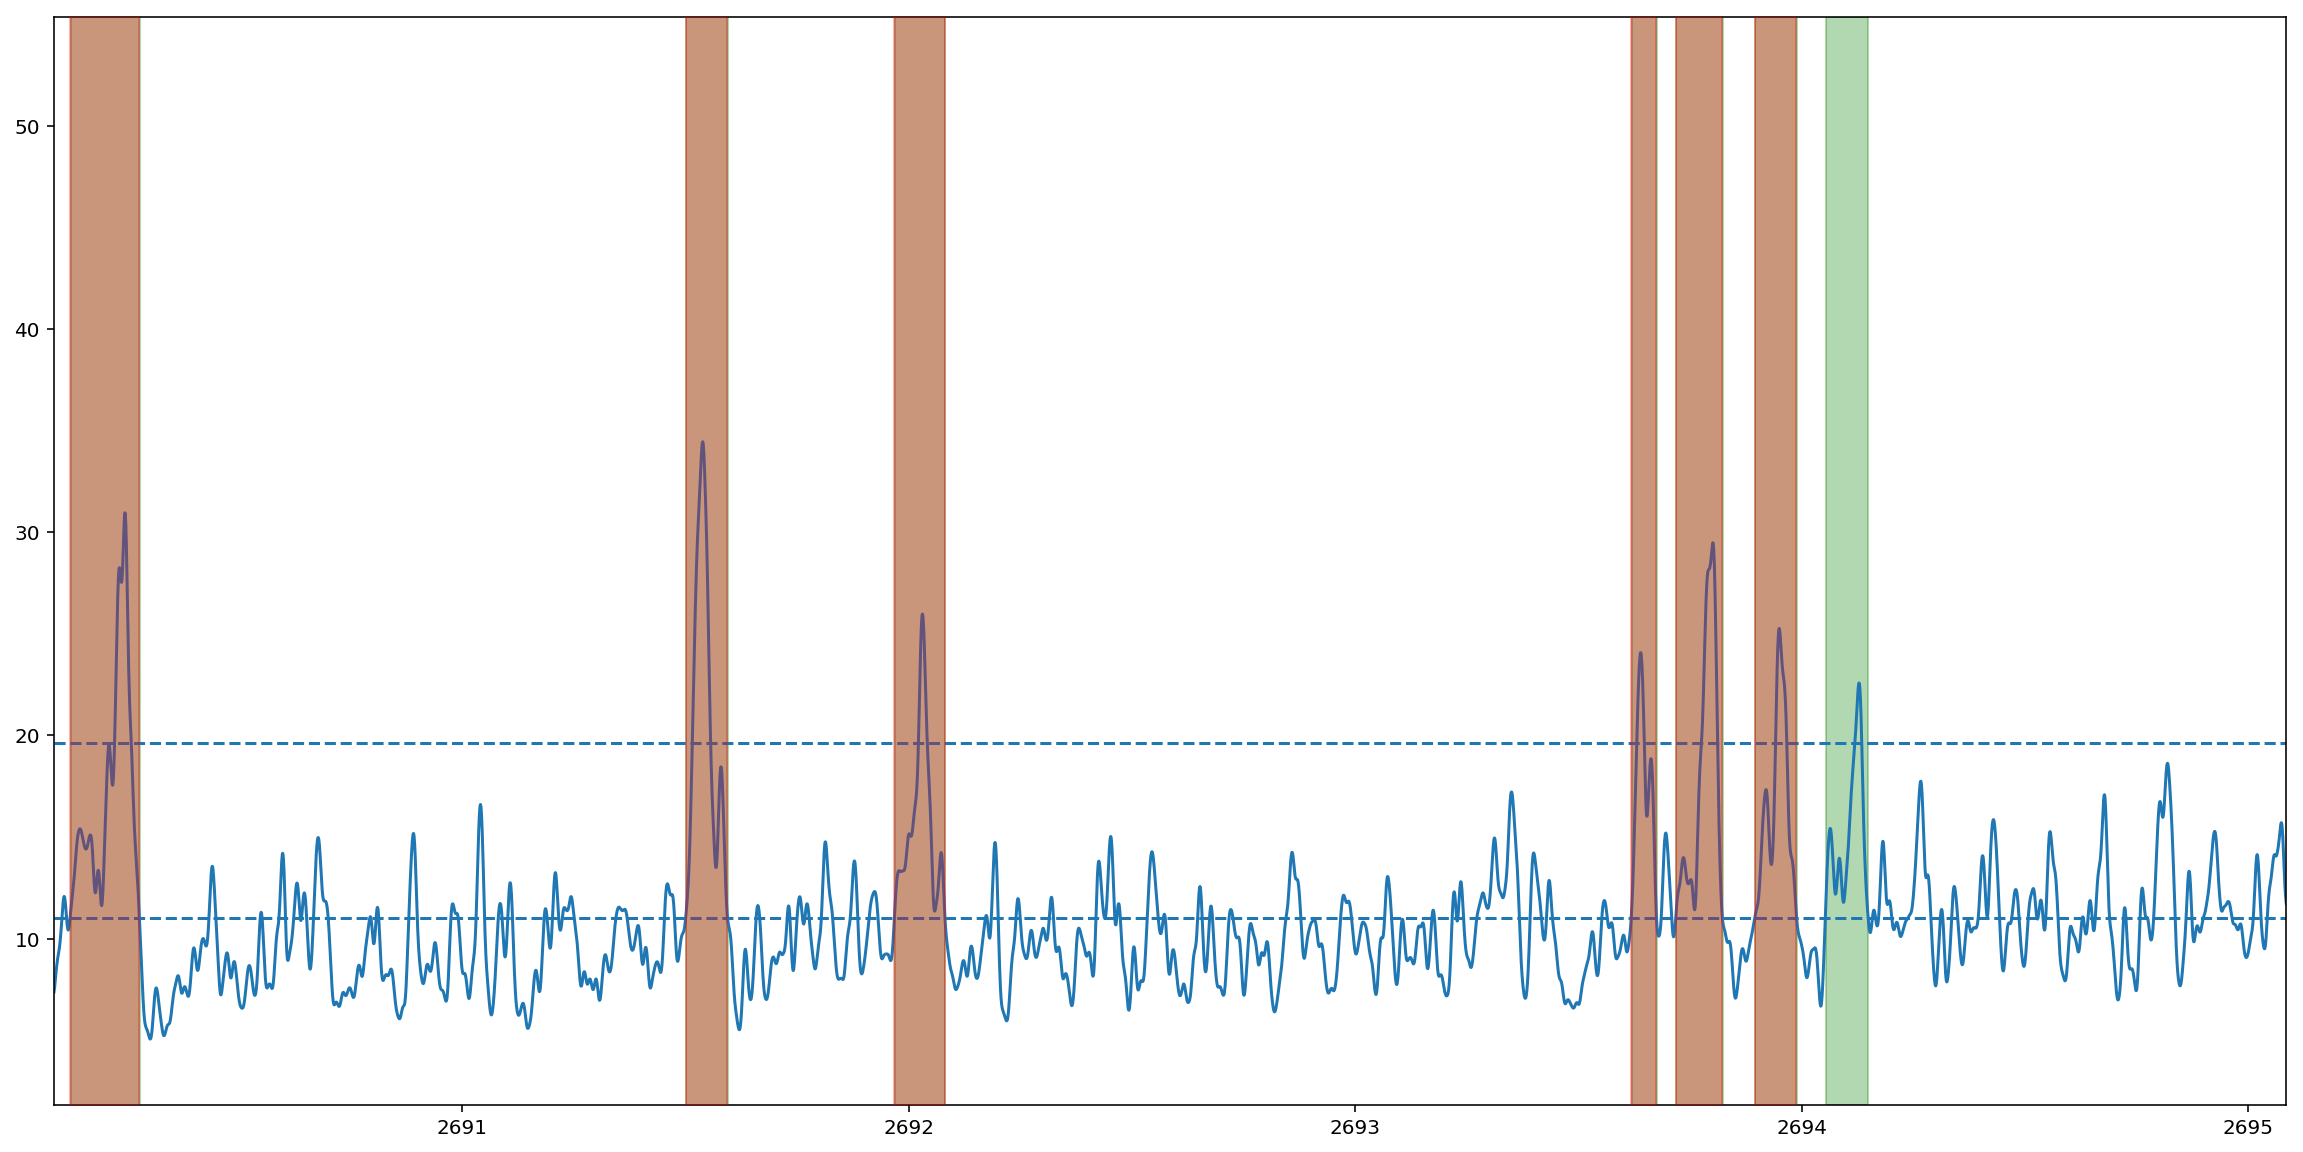

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

for ripple in candidate_ripple_times.index:
    c = candidate_ripple_times.loc[ripple]
    ax.axvspan(c.start_time.total_seconds(), c.end_time.total_seconds(), color='red', alpha=0.3, zorder=100)
    
for ripple in ripple_times2.index:
    c = ripple_times2.loc[ripple]
    ax.axvspan(c.start_time.total_seconds(), c.end_time.total_seconds(), color='green', alpha=0.3)

ax.plot(time.total_seconds(), powertrace)
    
ax.set_xlim((time.min().total_seconds() + 1010, time.min().total_seconds() + 1015))

ax.axhline(baseline, linestyle='--')
ax.axhline(thresh, linestyle='--')